In [ ]:
import json
import numpy as np
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

warnings.filterwarnings('ignore')

# ====================================
# 1. Load and preprocess dataset
# ====================================
with open("dataset.json", "r") as f:
    raw_data = json.load(f)

TIME_STEPS = 8
FEATURES_PER_STEP = 8

X = []
y = []

for item in raw_data:
    signal = item["data"]
    label = item["class"]
    if len(signal) >= TIME_STEPS * FEATURES_PER_STEP:
        signal = signal[:TIME_STEPS * FEATURES_PER_STEP]
        reshaped = np.array(signal).reshape(TIME_STEPS * FEATURES_PER_STEP)
        X.append(reshaped)
        y.append(label)

X = np.array(X)
y = np.array(y)

# ====================================
# 2. Data Augmentation with Noise
# ====================================
def augment_with_noise(X, y, noise_level=0.01, repeat=3):
    X_aug = []
    y_aug = []
    for x, label in zip(X, y):
        for _ in range(repeat):
            noisy = x + np.random.normal(0, noise_level, x.shape)
            X_aug.append(noisy)
            y_aug.append(label)
    return np.array(X_aug), np.array(y_aug)

X_aug1, y_aug1 = augment_with_noise(X, y, noise_level=0.02, repeat=3)
X_aug2, y_aug2 = augment_with_noise(X, y, noise_level=0.05, repeat=2)

X = np.concatenate([X, X_aug1, X_aug2])
y = np.concatenate([y, y_aug1, y_aug2])

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)
num_classes = y_categorical.shape[1]

# Reshape for Conv1D input
X = X.reshape((X.shape[0], X.shape[1], 1))

# Compute class weights
cw = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_encoded), y=y_encoded)
class_weights = dict(enumerate(cw))

# ====================================
# 3. 1D CNN Model Definition
# ====================================
def create_model(input_shape, num_classes):
    model = Sequential([
        Conv1D(32, 3, activation='relu', input_shape=input_shape),
        MaxPooling1D(),
        Dropout(0.2),
        Conv1D(64, 3, activation='relu'),
        GlobalAveragePooling1D(),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# ====================================
# 4. Stratified K-Fold Cross Validation
# ====================================
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []
fold = 1

for train_idx, test_idx in kf.split(X, y_encoded):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y_categorical[train_idx], y_categorical[test_idx]

    model = create_model((X.shape[1], 1), num_classes)

    # Callbacks
    callbacks = [
        EarlyStopping(monitor='loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5)
    ]

    # Train model
    model.fit(X_train, y_train,
              epochs=50,
              batch_size=8,
              callbacks=callbacks,
              class_weight=class_weights,
              verbose=0)

    # Evaluate
    y_pred = model.predict(X_test)
    acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
    accuracies.append(acc)
    print(f"✅ Fold {fold} Accuracy: {acc * 100:.2f}%")
    fold += 1




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
✅ Fold 1 Accuracy: 56.67%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
✅ Fold 2 Accuracy: 60.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
✅ Fold 3 Accuracy: 60.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
✅ Fold 4 Accuracy: 46.67%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
✅ Fold 5 Accuracy: 70.00%


In [ ]:
# inside your for‑fold loop, after you do:
y_pred = model.predict(X_test)

# 1) get the integer class indices
y_pred_idx = np.argmax(y_pred, axis=1)
y_true_idx = np.argmax(y_test, axis=1)

# 2) map back to your original class names
pred_labels = label_encoder.inverse_transform(y_pred_idx)
true_labels = label_encoder.inverse_transform(y_true_idx)

# 3) print a table showing which sample (original index) got which prediction
print("\nDetails for fold", fold)
print("orig_idx | true_label    | pred_label")
for orig_idx, t, p in zip(test_idx, true_labels, pred_labels):
    print(f"{orig_idx:8d} | {t:13s} | {p}")

# then you can still print your accuracy
acc = accuracy_score(y_true_idx, y_pred_idx)
print(f"✅ Fold {fold} Accuracy: {acc*100:.2f}%\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

Details for fold 6
orig_idx | true_label    | pred_label
       0 | sitting       | sitting
       8 | walking       | sitting
      11 | running       | running
      20 | falling       | falling
      23 | falling       | falling
      26 | sitting       | sitting
      27 | sitting       | sitting
      38 | sitting       | respiration
      44 | walking       | walking
      45 | walking       | walking
      56 | running       | respiration
      57 | running       | respiration
      59 | running       | running
      60 | running       | running
      70 | respiration   | sitting
      73 | respiration   | respiration
      77 | respiration   | respiration
      96 | falling       | falling
     101 | sitting       | sitting
     103 | sitting       | sitting
     114 | walking       | walking
     117 | walking       | sitting
     118 | walking       | walking
     120 | running       | respiration
     130 | respiration   | sitting
     

In [ ]:
import pandas as pd

df = pd.DataFrame({
    'orig_idx'  : test_idx,
    'true_label': true_labels,
    'pred_label': pred_labels
})
print(df)


    orig_idx   true_label   pred_label
0          0      sitting      sitting
1          8      walking      sitting
2         11      running      running
3         20      falling      falling
4         23      falling      falling
5         26      sitting      sitting
6         27      sitting      sitting
7         38      sitting  respiration
8         44      walking      walking
9         45      walking      walking
10        56      running  respiration
11        57      running  respiration
12        59      running      running
13        60      running      running
14        70  respiration      sitting
15        73  respiration  respiration
16        77  respiration  respiration
17        96      falling      falling
18       101      sitting      sitting
19       103      sitting      sitting
20       114      walking      walking
21       117      walking      sitting
22       118      walking      walking
23       120      running  respiration
24       130  respiration

In [ ]:
# ====================================
# 5. Final Report
# ====================================
print("\n📊 Final Cross-Validation Result:")
print(f"Average Accuracy: {np.mean(accuracies) * 100:.2f}%")

print("\n🧾 Classification Report (Final Fold):")
print(classification_report(np.argmax(y_test, axis=1),
                            np.argmax(y_pred, axis=1),
                            target_names=label_encoder.classes_,
                            zero_division=0))


📊 Final Cross-Validation Result:
Average Accuracy: 58.67%

🧾 Classification Report (Final Fold):
              precision    recall  f1-score   support

     falling       1.00      0.83      0.91         6
 respiration       0.50      0.67      0.57         6
     running       1.00      0.50      0.67         6
     sitting       0.50      0.83      0.62         6
     walking       1.00      0.67      0.80         6

    accuracy                           0.70        30
   macro avg       0.80      0.70      0.71        30
weighted avg       0.80      0.70      0.71        30



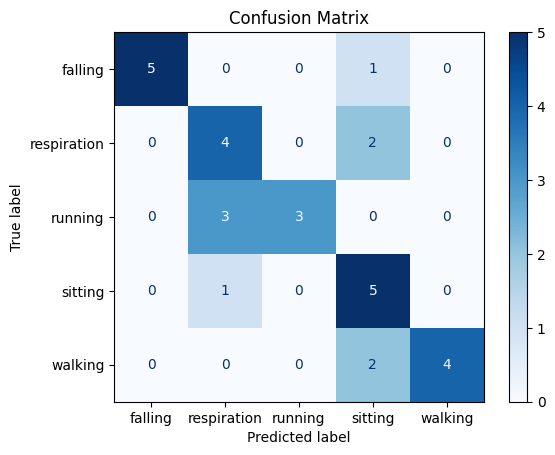

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# y_test: ground truth from last fold
# y_pred: predicted from last fold

cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Flatten the augmented data
X_rf = X.reshape((X.shape[0], -1))
y_rf = y_encoded

# Stratified 5-Fold
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_accuracies = []

for train_idx, test_idx in kf.split(X_rf, y_rf):
    X_train, X_test = X_rf[train_idx], X_rf[test_idx]
    y_train, y_test = y_rf[train_idx], y_rf[test_idx]

    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(X_train, y_train)
    preds = rf.predict(X_test)

    acc = accuracy_score(y_test, preds)
    rf_accuracies.append(acc)

print(f"\n📊 Random Forest Average Accuracy: {np.mean(rf_accuracies) * 100:.2f}%")



📊 Random Forest Average Accuracy: 100.00%


In [ ]:
from collections import defaultdict
import matplotlib.pyplot as plt

# To store metrics
class_metrics = defaultdict(lambda: defaultdict(list))  # class_metrics[class][metric] = list of values across folds


In [ ]:
from sklearn.metrics import classification_report

# Get metrics
report = classification_report(y_true_idx, y_pred_idx, output_dict=True, zero_division=0)
for label_idx, class_name in enumerate(label_encoder.classes_):
    if str(label_idx) in report:
        for metric in ['precision', 'recall', 'f1-score', 'support']:
            class_metrics[class_name][metric].append(report[str(label_idx)][metric])


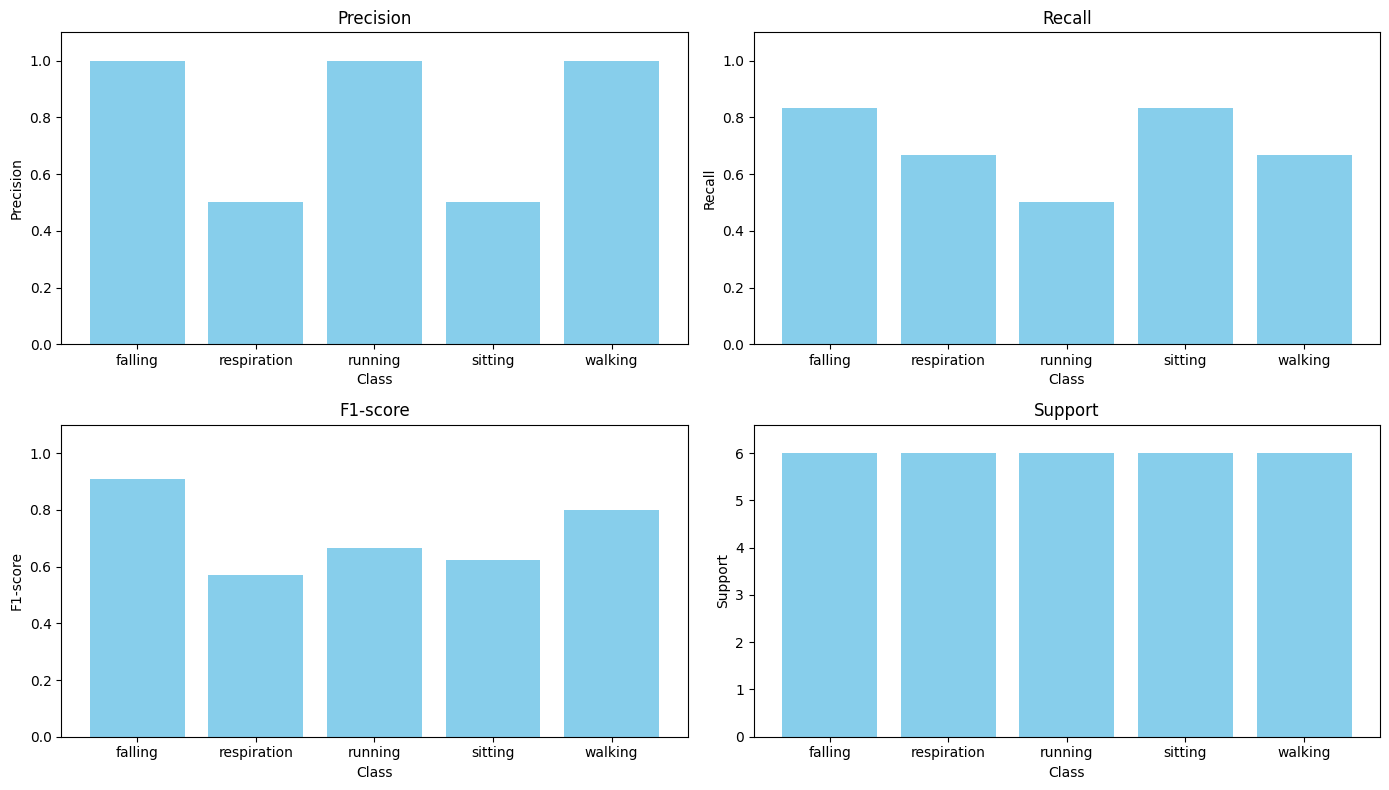

In [ ]:
# Plotting metrics for each class
metrics_to_plot = ['precision', 'recall', 'f1-score', 'support']
classes = list(label_encoder.classes_)

plt.figure(figsize=(14, 8))
for i, metric in enumerate(metrics_to_plot):
    plt.subplot(2, 2, i+1)
    values = [np.mean(class_metrics[c][metric]) for c in classes]
    plt.bar(classes, values, color='skyblue')
    plt.title(metric.capitalize())
    plt.ylim(0, 1.1 if metric != 'support' else max(values) * 1.1)
    plt.xlabel("Class")
    plt.ylabel(metric.capitalize())

plt.tight_layout()
plt.show()


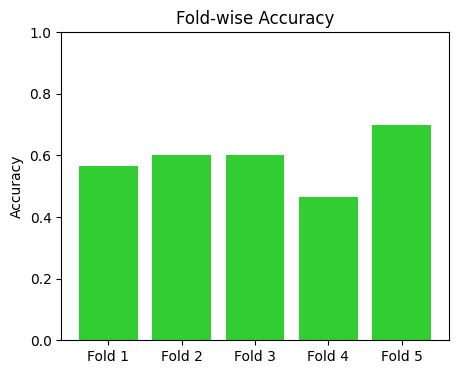

In [ ]:
plt.figure(figsize=(5, 4))
plt.bar(['Fold ' + str(i+1) for i in range(len(accuracies))], accuracies, color='limegreen')
plt.title("Fold-wise Accuracy")
plt.ylim(0, 1.0)
plt.ylabel("Accuracy")
plt.show()

